<a href="https://www.kaggle.com/code/shilonosovvladimir/stroke-detection?scriptVersionId=162022229" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install noise &> /dev/null
!pip install git+https://github.com/aimclub/eXplain-NNs &> /dev/null
!wget https://raw.githubusercontent.com/aimclub/eXplain-NNs/main/requirements.txt  &> /dev/null
!cat ./requirements.txt | grep -v torch > requirements_.txt
!pip install -r requirements_.txt  &> /dev/null

In [2]:
import math
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
from scipy.ndimage import zoom
from torch.optim import Adam
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score
import pickle
from matplotlib import pyplot as plt
from torch import autograd
import noise
import eXNN.topology
from tqdm import tqdm
import pandas as pd

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels):
        super(InceptionModule, self).__init__()

        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=1)
        
        self.reduction_conv3 = nn.Conv3d(in_channels, 64, kernel_size=1, padding=1)
        self.conv3 = nn.Conv3d(64, 64, kernel_size=3, padding=1)
        
        self.reduction_conv5 = nn.Conv3d(in_channels, 64, kernel_size=1, padding=1)
        self.conv5 = nn.Conv3d(64, 64, kernel_size=5, padding=1)
        
        self.pool = nn.MaxPool3d(kernel_size=3, stride=1, padding=1)
        self.reduction_conv_pool = nn.Conv3d(in_channels, 64, kernel_size=1, padding=1)

    def forward(self, x):
        
        out1 = F.relu(self.conv1(x))

        reduced_in3 = F.relu(self.reduction_conv3(x))
        out3 = F.relu(self.conv3(reduced_in3))

        reduced_in5 = F.relu(self.reduction_conv5(x))
        out5 = F.relu(self.conv5(reduced_in5))
        
        out_pool = self.pool(x)
        reduced_out_pool = F.relu(self.reduction_conv_pool(out_pool))
        
        out1 = F.pad(out1, (1, 1, 1, 1, 1, 1), value=0)
        out5 = F.pad(out5, (1, 1, 1, 1, 1, 1), value=0)

        out = torch.cat((out1, out3, out5, reduced_out_pool), dim=1)
        
        return out

class DeepSymNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.im1 = InceptionModule(1)
        self.im2 = InceptionModule(256)
        self.im3 = InceptionModule(256)
        self.im4 = InceptionModule(256)
        self.im5 = InceptionModule(256)
        self.im6 = InceptionModule(256)
        
        self.pool = nn.MaxPool3d(kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(in_features=38522880, out_features=2)
        
    def activations_hook(self, grad):
        self.gradients = grad

    def get_activations_gradient(self):
        return self.gradients

    def forward_once(self, X):

        X = X.unsqueeze(1)

        X = self.im1(X)
        X = self.im2(X)
        X = self.im3(X)
        X = self.im4(X)

        return X
    
    def features_conv(self, X_left, X_right):
        X_left = self.forward_once(X_left)
        X_right = self.forward_once(X_right)

        X = X_left - X_right

        X = self.im5(X)
        X = self.im6(X)
        
        return X
    
    def get_activations(self, X_left, X_right):
        return self.features_conv(X_left, X_right)

    def forward(self, *args):
        if len(args) == 2:
            X_left = args[0]
            X_right = args[1]
        elif len(args) == 1:
            X_left, X_right = args[0][0], args[0][1]
        else:
            raise Exception('arguements have to be left and right tesnsors')
        
        X = self.features_conv(X_left, X_right)
        
        X.register_hook(self.activations_hook)
        
        X = self.pool(X)
        X = X.view(X.shape[0], 38522880)
        X = F.sigmoid(self.fc(X))

        return X


In [4]:
class InceptionModule2d(nn.Module):
    def __init__(self, in_channels):
        super(InceptionModule2d, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=1)
        
        self.reduction_conv3 = nn.Conv2d(in_channels, 64, kernel_size=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.reduction_conv5 = nn.Conv2d(in_channels, 64, kernel_size=1, padding=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=5, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.reduction_conv_pool = nn.Conv2d(in_channels, 64, kernel_size=1, padding=1)

    def forward(self, x):
        
        out1 = F.relu(self.conv1(x))

        reduced_in3 = F.relu(self.reduction_conv3(x))
        out3 = F.relu(self.conv3(reduced_in3))

        reduced_in5 = F.relu(self.reduction_conv5(x))
        out5 = F.relu(self.conv5(reduced_in5))
        
        out_pool = self.pool(x)
        reduced_out_pool = F.relu(self.reduction_conv_pool(out_pool))
        
        out1 = F.pad(out1, (1, 1, 1, 1, 1, 1), value=0)
        out5 = F.pad(out5, (1, 1, 1, 1, 1, 1), value=0)

        out = torch.cat((out1, out3, out5, reduced_out_pool), dim=1)
        
        return out

class DeepSymNet2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.im1 = InceptionModule2d(1)
        self.im2 = InceptionModule2d(260)
        self.im3 = InceptionModule2d(260)
        self.im4 = InceptionModule2d(260)
        self.im5 = InceptionModule2d(260)
        self.im6 = InceptionModule2d(260)
        
        self.pool = nn.MaxPool3d(kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(in_features=1029600, out_features=2)
        
    def forward_once(self, X):

        X = X.unsqueeze(1)

        X = self.im1(X)
        X = self.im2(X)
        X = self.im3(X)
        X = self.im4(X)

        return X

    def forward(self, X_left, X_right):
        
        X_left = self.forward_once(X_left)
        X_right = self.forward_once(X_right)

        X = torch.abs(X_left - X_right)

        X = self.im5(X)
        X = self.im6(X)
        
        X = self.pool(X)
        X = X.view(X.shape[0], 1029600)
        X = F.sigmoid(self.fc(X))
        
        return X

In [5]:
path = '/kaggle/input/mri-flair-ischemic-stroke-dataset/normalized_hemispheres/'

entity_shape = (32, 78, 26)
learning_rate = 1e-6
learning_rate_2d = 1e-6
max_epoch = 15
max_epoch_2d = 40
batch_size = 2
batch_size_2d = 2

model = DeepSymNet()
model_2d = DeepSymNet2d()

optimizer = Adam(model.parameters(), lr=learning_rate)
optimizer_2d = Adam(model_2d.parameters(), lr=learning_rate_2d)
criterion = nn.BCELoss()


normal_files = list(map(lambda el: path + 'normal/' + el + '/', os.listdir(path + 'normal/')))
pathology_files = list(map(lambda el: path + 'pathology/' + el + '/', os.listdir(path + 'pathology/')))

normal_labels = torch.Tensor([[0, 1]] * len(normal_files))
pathology_labels = torch.Tensor([[1, 0]] * len(pathology_files))

files = normal_files + pathology_files
labels = torch.cat([normal_labels, pathology_labels], dim=0)

train_files, test_files, train_labels, test_labels = train_test_split(files, labels, random_state=1, test_size=0.2, stratify=labels)

In [6]:
if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda")
else:
    print("CUDA is not available")
    device = torch.device("cpu")

    
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

train_labels = train_labels.to(device)
test_labels = test_labels.to(device)
model = model.to(device)
model_2d = model_2d.to(device)

CUDA is available
Let's use 2 GPUs!


In [7]:
def evaluate():
    loss = 0
    real = test_labels.cpu().numpy()
    outs = np.zeros(test_labels.shape)
    model.eval()
    for i, (el, y) in tqdm(enumerate(zip(test_files, test_labels))):
        left = torch.Tensor(nib.load(el + 'left.nii').get_fdata())
        right = torch.Tensor(nib.load(el + 'right.nii').get_fdata())
        out = model(torch.unsqueeze(left, 0).to(device), torch.unsqueeze(right, 0).to(device))
        loss += criterion(out, y.unsqueeze(dim=0)).detach().cpu().numpy()
        outs[i] = out.detach().cpu().numpy()
    print(classification_report(real, outs > 0.5))
    print('ROC AUC Score:', roc_auc_score(real[:,1], outs[:,1]))
    print('Val Loss:', loss)
    print('Accuracy score:', accuracy_score(real, outs > 0.5))
    model.train()

def evaluate_2d():
    loss = 0
    real = test_labels.cpu().numpy()
    outs = np.zeros(test_labels.shape)
    model_2d.eval()
    for i, (el, y) in tqdm(enumerate(zip(test_files, test_labels))):
        left = torch.Tensor(nib.load(el + 'left.nii').get_fdata()[:,:,13])
        right = torch.Tensor(nib.load(el + 'right.nii').get_fdata()[:,:,13])
        out = model_2d(torch.unsqueeze(left, 0).to(device), torch.unsqueeze(right, 0).to(device))
        loss += criterion(out, y.unsqueeze(dim=0)).detach().cpu().numpy()
        outs[i] = out.detach().cpu().numpy()
    print(classification_report(real, outs > 0.5))
    print('ROC AUC Score:', roc_auc_score(real[:,1], outs[:,1]))
    print('Val Loss:', loss)
    print('Accuracy score:', accuracy_score(real, outs > 0.5))
    model.train()

In [8]:
model.train()
for epoch in tqdm(range(max_epoch)):
    for i in range(math.ceil(len(train_files) / batch_size)):
        optimizer.zero_grad()
        X = torch.zeros(2, len(train_files) - i * batch_size if (i + 1) * batch_size >= len(train_files) else batch_size, *entity_shape)
        y = train_labels[i*batch_size:(i+1)*batch_size]
        for j in range(batch_size):
            if i * batch_size + j < len(train_files):
                left = torch.Tensor(nib.load(train_files[i * batch_size + j] + 'left.nii').get_fdata())
                right = torch.Tensor(nib.load(train_files[i * batch_size + j] + 'right.nii').get_fdata())
                X[0, j], X[1, j] = left, right
                X = X.to(device)
        outputs = model(X[0], X[1])

        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

100%|██████████| 15/15 [50:16<00:00, 201.13s/it]


In [9]:
evaluate()

42it [00:19,  2.21it/s]

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.96      1.00      0.98        22

   micro avg       0.98      0.98      0.98        42
   macro avg       0.98      0.97      0.98        42
weighted avg       0.98      0.98      0.98        42
 samples avg       0.98      0.98      0.98        42

ROC AUC Score: 0.9954545454545454
Val Loss: 4.060118937679363
Accuracy score: 0.9761904761904762


In [10]:
if isinstance(model, nn.DataParallel):
    model = model.module.cpu().eval()
else:
    model = model.cpu().eval()

im1_embs_3d = []
im2_embs_3d = []
im3_embs_3d = []
im4_embs_3d = []

for i in tqdm(range(len(test_files))):
    left = torch.unsqueeze(torch.Tensor(nib.load(test_files[i] + 'left.nii').get_fdata()), 0)
    right = torch.unsqueeze(torch.Tensor(nib.load(test_files[i] + 'right.nii').get_fdata()), 0)
    im1_emb_3d = model.im1(torch.unsqueeze(left, 0)).detach()
    im2_emb_3d = model.im2(im1_emb_3d).detach()
    im3_emb_3d = model.im3(im2_emb_3d).detach()
    im4_emb_3d = model.im4(im3_emb_3d).detach()
    
    im1_embs_3d.append(im1_emb_3d.cpu())
    im2_embs_3d.append(im2_emb_3d.cpu())
    im3_embs_3d.append(im3_emb_3d.cpu())
    im4_embs_3d.append(im4_emb_3d.cpu())

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    
model = model.to(device)

100%|██████████| 42/42 [03:34<00:00,  5.10s/it]


In [11]:
im1_barcode_3d = eXNN.topology.get_data_barcode(torch.cat(im1_embs_3d), hom_type = "standard", coefs_type = "2")
del im1_embs_3d
im2_barcode_3d = eXNN.topology.get_data_barcode(torch.cat(im2_embs_3d), hom_type = "standard", coefs_type = "2")
del im2_embs_3d
im3_barcode_3d = eXNN.topology.get_data_barcode(torch.cat(im3_embs_3d), hom_type = "standard", coefs_type = "2")
del im3_embs_3d
im4_barcode_3d = eXNN.topology.get_data_barcode(torch.cat(im4_embs_3d), hom_type = "standard", coefs_type = "2")
del im4_embs_3d

In [12]:
model_2d.train()
for epoch in tqdm(range(max_epoch_2d)):
    for i in range(math.ceil(len(train_files) / batch_size)):
        optimizer.zero_grad()
        X = torch.zeros(2, len(train_files) - i * batch_size if (i + 1) * batch_size >= len(train_files) else batch_size, *entity_shape[:2])
        y = train_labels[i*batch_size:(i+1)*batch_size]
        for j in range(batch_size):
            if i * batch_size + j < len(train_files):
                left = torch.Tensor(nib.load(train_files[i * batch_size + j] + 'left.nii').get_fdata()[:,:,13])
                right = torch.Tensor(nib.load(train_files[i * batch_size + j] + 'right.nii').get_fdata()[:,:,13])
                X[0, j], X[1, j] = left, right
                X = X.to(device)
        outputs = model_2d(X[0], X[1])

        loss = criterion(outputs, y)
        loss.backward()
        optimizer_2d.step()

100%|██████████| 40/40 [02:59<00:00,  4.48s/it]


In [13]:
evaluate_2d()

42it [00:00, 60.30it/s]

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        20
           1       0.95      0.86      0.90        22

   micro avg       0.90      0.90      0.90        42
   macro avg       0.91      0.91      0.90        42
weighted avg       0.91      0.90      0.90        42
 samples avg       0.90      0.90      0.90        42

ROC AUC Score: 0.9659090909090909
Val Loss: 11.908925117473853
Accuracy score: 0.9047619047619048


In [14]:
if isinstance(model_2d, nn.DataParallel):
    model_2d = model_2d.module.cpu().eval()
else:
    model_2d = model_2d.cpu().eval()

im1_embs_2d = []
im2_embs_2d = []
im3_embs_2d = []
im4_embs_2d = []

for i in tqdm(range(len(test_files))):
    left = torch.unsqueeze(torch.Tensor(nib.load(test_files[i] + 'left.nii').get_fdata()[:,:,13]), 0)
    right = torch.unsqueeze(torch.Tensor(nib.load(test_files[i] + 'right.nii').get_fdata()[:,:,13]), 0)
    im1_emb_2d = model_2d.im1(torch.unsqueeze(left, 0)).detach()
    im2_emb_2d = model_2d.im2(im1_emb_2d).detach()
    im3_emb_2d = model_2d.im3(im2_emb_2d).detach()
    im4_emb_2d = model_2d.im4(im3_emb_2d).detach()
    
    im1_embs_2d.append(im1_emb_2d.cpu())
    im2_embs_2d.append(im2_emb_2d.cpu())
    im3_embs_2d.append(im3_emb_2d.cpu())
    im4_embs_2d.append(im4_emb_2d.cpu())

100%|██████████| 42/42 [00:03<00:00, 13.56it/s]


In [15]:
im1_barcode_2d = eXNN.topology.get_data_barcode(torch.cat(im1_embs_2d), hom_type = "standard", coefs_type = "2")
del im1_embs_2d
im2_barcode_2d = eXNN.topology.get_data_barcode(torch.cat(im2_embs_2d), hom_type = "standard", coefs_type = "2")
del im2_embs_2d
im3_barcode_2d = eXNN.topology.get_data_barcode(torch.cat(im3_embs_2d), hom_type = "standard", coefs_type = "2")
del im3_embs_2d
im4_barcode_2d = eXNN.topology.get_data_barcode(torch.cat(im4_embs_2d), hom_type = "standard", coefs_type = "2")
del im4_embs_2d

if torch.cuda.device_count() > 1:
    model_2d = nn.DataParallel(model_2d)

model_2d = model_2d.to(device)

In [16]:
def plot_barcodes_overlay(barcode1, barcode2, name):
    homologies1 = list(barcode1.keys())
    homologies2 = list(barcode2.keys())
    nplots = len(homologies1)
    fig, ax = plt.subplots(nplots, figsize=(15, min(10, 5 * nplots)))
    if nplots == 1:
        ax = [ax]

    for i in range(nplots):
        ax[i].set_title(name)
        ax[i].set_ylim([-0.05, 1.05])
        bars1 = barcode1['H0']
        bars2 = barcode2['H0']
        n = len(bars1)
        for j in range(n):
            bar1 = bars1[j]
            bar2 = bars2[j]
            ax[i].plot([bar2[0], bar2[1]], [j / n, j / n], color="blue", label='3D' if j == 0 else None)
            ax[i].plot([bar1[0], bar1[1]], [j / n, j / n], color="red", label='2D' if j == 0 else None)
        labels = ["" for _ in range(len(ax[i].get_yticklabels()))]
        ax[i].set_yticks(ax[i].get_yticks())
        ax[i].set_yticklabels(labels)
        
        ax[i].legend()

    if nplots == 1:
        ax = ax[0]
    plt.close(fig)
    return fig

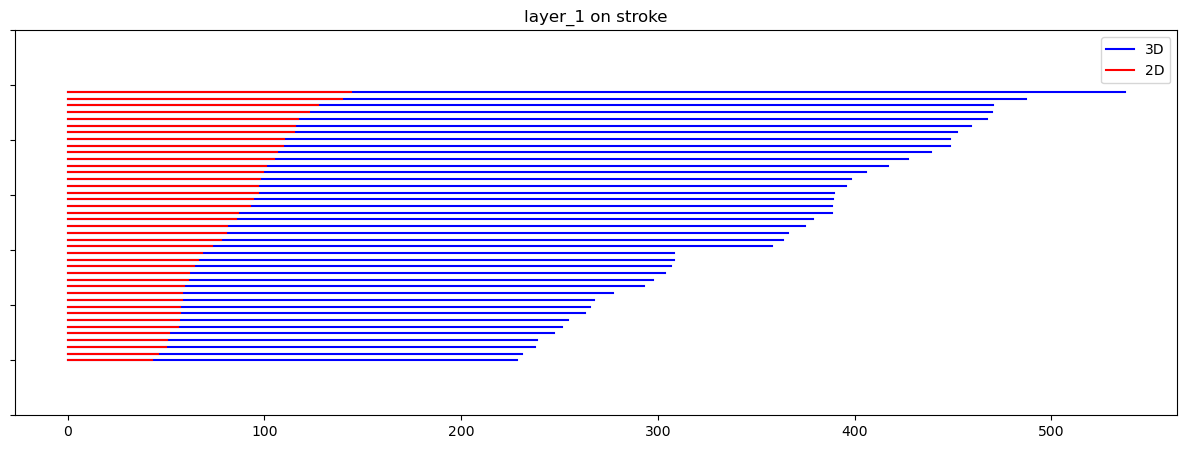

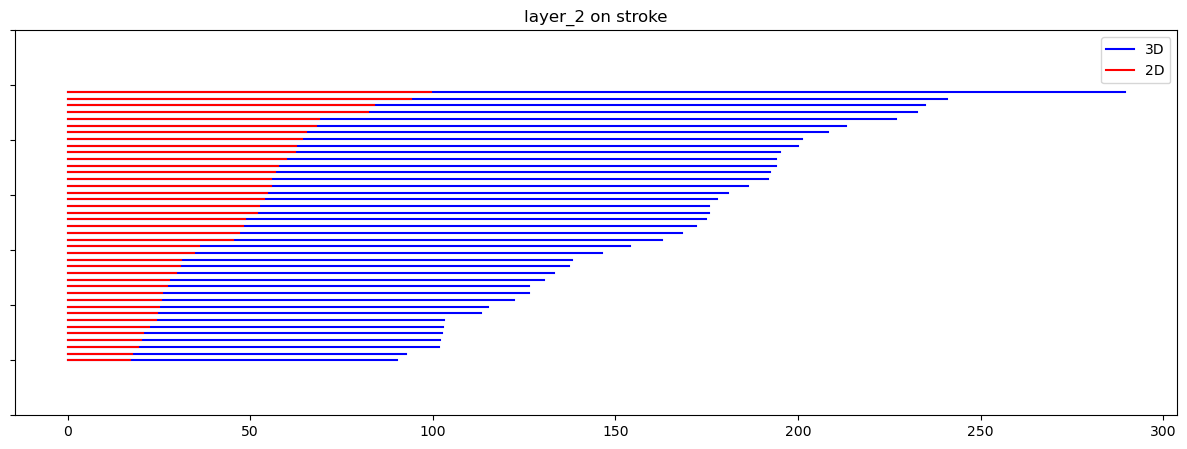

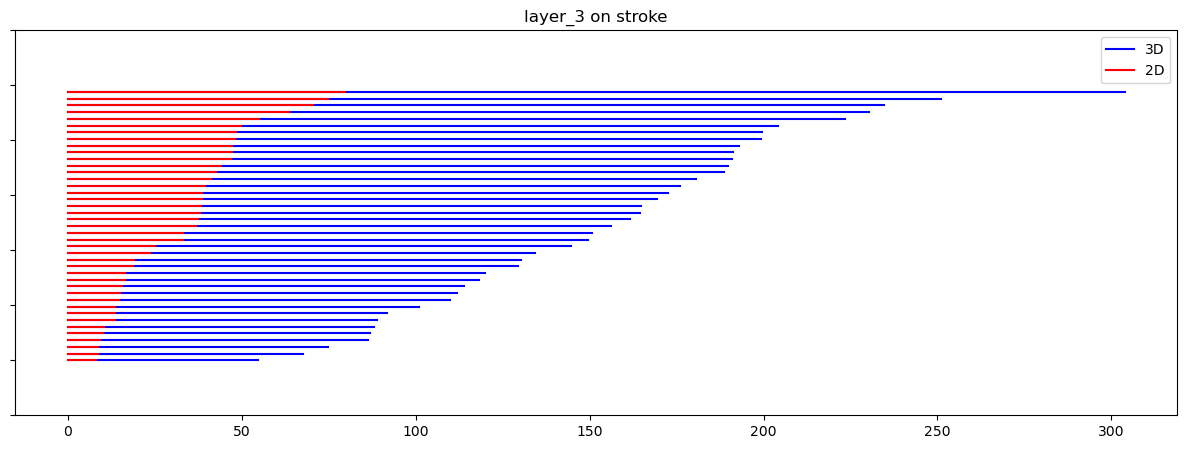

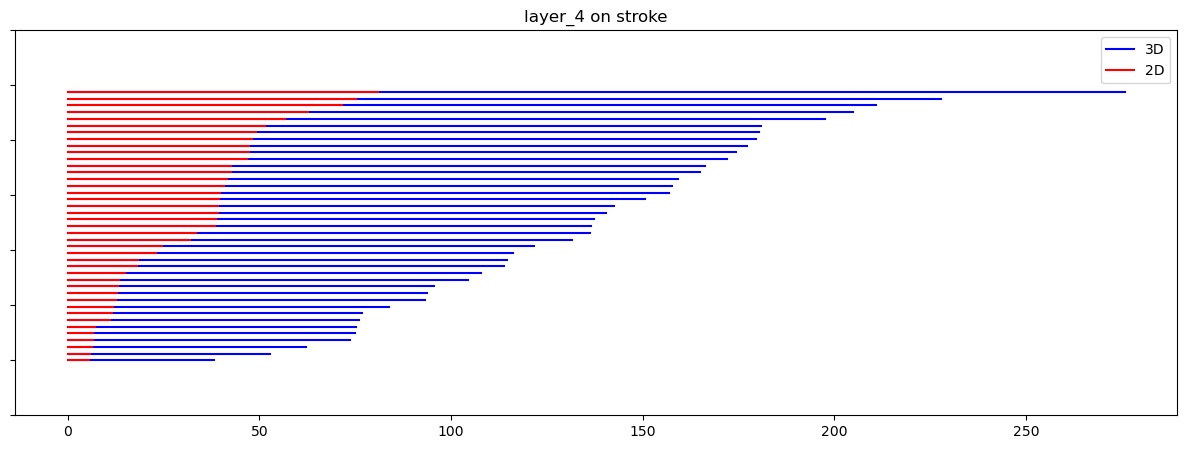

In [17]:
fig1 = plot_barcodes_overlay(im1_barcode_2d, im1_barcode_3d, 'layer_1 on stroke')
fig2 = plot_barcodes_overlay(im2_barcode_2d, im2_barcode_3d, 'layer_2 on stroke')
fig3 = plot_barcodes_overlay(im3_barcode_2d, im3_barcode_3d, 'layer_3 on stroke')
fig4 = plot_barcodes_overlay(im4_barcode_2d, im4_barcode_3d, 'layer_4 on stroke')

fig1.savefig('im1.png')
fig2.savefig('im2.png')
fig3.savefig('im3.png')
fig4.savefig('im4.png')

display(fig1)
display(fig2)
display(fig3)
display(fig4)

In [18]:
os.mkdir('/kaggle/working/importances/')
os.mkdir('/kaggle/working/importances/normal/')
os.mkdir('/kaggle/working/importances/pathology/')

In [19]:
def get_heat_map(pred, layer_out):
    pooled_grad = autograd.grad(pred, layer_out, retain_graph=True)[0][0].mean(dim=(1,2,3))
    heat_map = torch.zeros_like(layer_out[0])
    for i in range(pooled_grad.shape[0]):
        heat_map[i] = layer_out[0, i] * pooled_grad[i]
    return heat_map.mean(0).detach()

In [20]:
if isinstance(model, nn.DataParallel):
    model = model.module

importances_path = '/kaggle/working/importances/'

for el, y in tqdm(zip(files, labels)):
    
    left_data = nib.load(el + 'left.nii')
    right_data = nib.load(el + 'right.nii')
    
    left = torch.unsqueeze(torch.Tensor(left_data.get_fdata()), 0).to(device)
    right = torch.unsqueeze(torch.Tensor(right_data.get_fdata()), 0).to(device)
    
    left_out1 = model.im1(torch.unsqueeze(left, 0))
    left_out2 = model.im2(left_out1)
    left_out3 = model.im3(left_out2)
    left_out4 = model.im4(left_out3)
    
    right_out1 = model.im1(torch.unsqueeze(right, 0))
    right_out2 = model.im2(right_out1)
    right_out3 = model.im3(right_out2)
    right_out4 = model.im4(right_out3)
    
    out = left_out4 - right_out4
    
    out = model.im5(out)
    out = model.im6(out)
        
    out = model.pool(out)
    out = out.view(out.shape[0], 38522880)
    pred = F.sigmoid(model.fc(out))
    
    left_map = get_heat_map(pred[0][0] + (1 - pred[0][1]), left_out1)
    right_map = get_heat_map(pred[0][0] + (1 - pred[0][1]), right_out1)
    imp_arr1 = np.concatenate([left_map.cpu().numpy(), right_map.cpu().numpy()[::-1]])
    
    left_map = get_heat_map(pred[0][0] + (1 - pred[0][1]), left_out2)
    right_map = get_heat_map(pred[0][0] + (1 - pred[0][1]), right_out2)
    imp_arr2 = np.concatenate([left_map.cpu().numpy(), right_map.cpu().numpy()[::-1]])
    
    left_map = get_heat_map(pred[0][0] + (1 - pred[0][1]), left_out3)
    right_map = get_heat_map(pred[0][0] + (1 - pred[0][1]), right_out3)
    imp_arr3 = np.concatenate([left_map.cpu().numpy(), right_map.cpu().numpy()[::-1]])
    
    left_map = get_heat_map(pred[0][0] + (1 - pred[0][1]), left_out4)
    right_map = get_heat_map(pred[0][0] + (1 - pred[0][1]), right_out4)
    imp_arr4 = np.concatenate([left_map.cpu().numpy(), right_map.cpu().numpy()[::-1]])
    
    del left
    del right
    del left_out1
    del left_out2
    del left_out3
    del left_out4
    del right_out1
    del right_out2
    del right_out3
    del right_out4
    del out
    del pred
    
    imp_data1 = nib.Nifti1Image(imp_arr1, affine=left_data.affine)
    imp_data2 = nib.Nifti1Image(imp_arr2, affine=left_data.affine)
    imp_data3 = nib.Nifti1Image(imp_arr3, affine=left_data.affine)
    imp_data4 = nib.Nifti1Image(imp_arr4, affine=left_data.affine)
    
    del imp_arr1
    del imp_arr2
    del imp_arr3
    del imp_arr4
    
    save_to = importances_path + os.sep.join(el.split(os.sep)[-3:-1])
    
    os.mkdir(save_to)
    
    nib.save(imp_data1, save_to + os.sep + '1')
    nib.save(imp_data1, save_to + os.sep + '2')
    nib.save(imp_data1, save_to + os.sep + '3')
    nib.save(imp_data1, save_to + os.sep + '4')
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

208it [07:09,  2.06s/it]


In [21]:
!zip -rq archive.zip /kaggle/working/importances

In [22]:
def get_noise_tensor(x: int,
                     y: int,
                     z: int,
                     base: float=0,
                     octaves: int=3,
                     persistence: float=0.4) -> np.array:
    tensor = np.zeros([x, y, z])
    coef = 0.1
    for i in range(x):
        for j in range(y):
            for k in range(z):
                tensor[i, j, k] = noise.pnoise3(coef * i,
                                                coef * j,
                                                coef * k,
                                                octaves=octaves,
                                                persistence=persistence,
                                                base=base)
    return tensor



def smooth(tensor: np.array, kernel_size: int=3) -> np.array:
    filter_ = torch.ones(1, 1, *[kernel_size] * 3) / kernel_size ** 3
    unsqueezed_tensor = torch.Tensor(tensor).view(1,1, *tensor.shape)
    return F.conv3d(unsqueezed_tensor, filter_, padding='same').view(*tensor.shape).numpy()



def add_intensive_region(tensor: np.array, base: float=0) -> np.array:
    regions = get_noise_tensor(*tensor.shape, octaves=1, persistence=0.1, base=base)
    
    zoom_factor = 2
    x_pad = regions.shape[0] * (zoom_factor - 1) // 2
    y_pad = regions.shape[1] * (zoom_factor - 1) // 2
    z_pad = regions.shape[2] * (zoom_factor - 1) // 2
    
    regions = zoom(regions, zoom_factor)[x_pad:-x_pad,y_pad:-y_pad,z_pad:-z_pad]
    
    p = np.percentile(regions, 90)
    regions = regions > p
    
    intencive_tensor = tensor.copy()  
    intencive_tensor += smooth(regions, kernel_size=2)
    
    return intencive_tensor




def add_stroke(tensor: np.array, base: int) -> np.array:
    
    regions = get_noise_tensor(*tensor.shape, octaves=1, persistence=0.1, base=base)
    
    zoom_factor = 3
    x_pad = regions.shape[0] * (zoom_factor - 1) // 2
    y_pad = regions.shape[1] * (zoom_factor - 1) // 2
    z_pad = regions.shape[2] * (zoom_factor - 1) // 2
    regions = zoom(regions, zoom_factor)[x_pad:-x_pad,y_pad:-y_pad,z_pad:-z_pad]
    
    p = np.percentile(regions, 80)
    regions = regions > p    
    
    stroke_tensor = tensor.copy()
    stroke_tensor += smooth(regions, kernel_size=5)
    
    return stroke_tensor

def validate(model: nn.Module, test_X: np.array, test_y: np.array):
    outs = np.zeros([len(test_X), 2])
    preds = np.zeros([len(test_X), 2])
    
    model.eval()
    for i in tqdm(range(len(test_X))):
        left = torch.Tensor(test_X[i][:entity_shape[0]].copy()).unsqueeze(dim=0).to(device)
        right = torch.Tensor(test_X[i][entity_shape[0]:][::-1].copy()).unsqueeze(dim=0).to(device)

        output = model(left, right).detach().cpu().numpy()
        pred = output > 0.5
        outs[i] = output
        preds[i] = pred
    model.train()

    report = classification_report(test_y, preds, target_names=['normal', 'stroke'])
    print(report)
    print('roc auc:', roc_auc_score(test_y, outs))
    print('accuracy:', accuracy_score(test_y, preds))

In [23]:
normal_X = []
for i in tqdm(range(100)):
    normal_X.append(add_intensive_region(get_noise_tensor(entity_shape[0] * 2, *entity_shape[1:], base=i), base=i+1))
stroke_X = []
for i in tqdm(range(100, 200)):
    stroke_X.append(add_stroke(get_noise_tensor(entity_shape[0] * 2, *entity_shape[1:], base=i), base=i+1))

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_27/1114186969.py:25: UserWarning:

Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/Convolution.cpp:1003.)

100%|██████████| 100/100 [03:06<00:00,  1.87s/it]


In [24]:
X_3d = normal_X + stroke_X
X_2d = [entity[:,:,13] for entity in X_3d]
y = [[0, 1]] * 100 + [[1, 0]] * 100

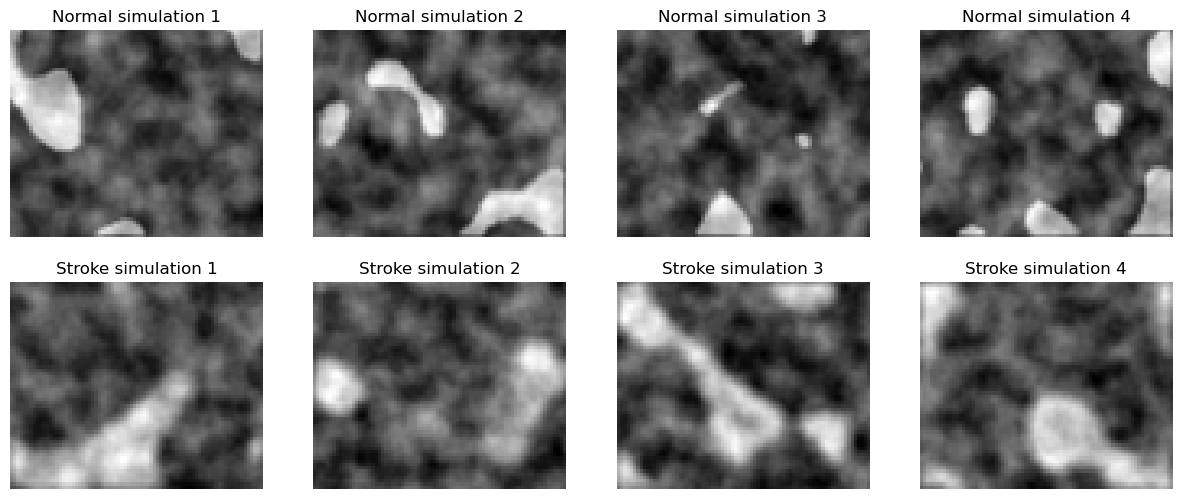

In [25]:
fig, axs = plt.subplots(2, 4, figsize=(15, 6))
for i in range(4):
    axs[0][i].imshow(normal_X[i][:,:,13], cmap='gray')
    axs[0][i].set_title(f'Normal simulation {i+1}')
    axs[1][i].imshow(stroke_X[i][:,:,13], cmap='gray')
    axs[1][i].set_title(f'Stroke simulation {i+1}')
    axs[0][i].set_axis_off()
    axs[1][i].set_axis_off()
plt.show()

In [26]:
train_X_3d, test_X_3d, train_y_3d, test_y_3d = train_test_split(X_3d, y, random_state=1, test_size=0.3, stratify=y)
train_X_2d, test_X_2d, train_y_2d, test_y_2d = train_test_split(X_2d, y, random_state=1, test_size=0.3, stratify=y)

In [27]:
model = DeepSymNet()
model_2d = DeepSymNet2d()

optimizer = Adam(model.parameters(), lr=learning_rate)
optimizer_2d = Adam(model_2d.parameters(), lr=learning_rate_2d)


if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    model_2d = nn.DataParallel(model_2d)

model = model.to(device)
model_2d = model_2d.to(device)

In [28]:
model = model.to(device).train()
for epoch in tqdm(range(max_epoch)):
    for i in range(math.ceil(len(train_X_3d) / batch_size)):
        batch_X = np.array(train_X_3d[i * batch_size:(i + 1) * batch_size])
        batch_y = torch.Tensor(np.array(train_y_3d[i * batch_size:(i + 1) * batch_size])).to(device)
        
        left_batch = torch.Tensor(batch_X[:,:entity_shape[0]].copy()).to(device)
        right_batch = torch.Tensor(batch_X[:,entity_shape[0]:][:,::-1].copy()).to(device)
        
        optimizer.zero_grad()
        outputs = model(left_batch, right_batch)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

100%|██████████| 15/15 [42:10<00:00, 168.67s/it]


In [29]:
validate(model, test_X_3d, test_y_3d)

100%|██████████| 60/60 [00:27<00:00,  2.16it/s]

              precision    recall  f1-score   support

      normal       1.00      0.47      0.64        30
      stroke       0.65      1.00      0.79        30

   micro avg       0.73      0.73      0.73        60
   macro avg       0.83      0.73      0.71        60
weighted avg       0.83      0.73      0.71        60
 samples avg       0.73      0.73      0.73        60

roc auc: 0.9455555555555555
accuracy: 0.7333333333333333


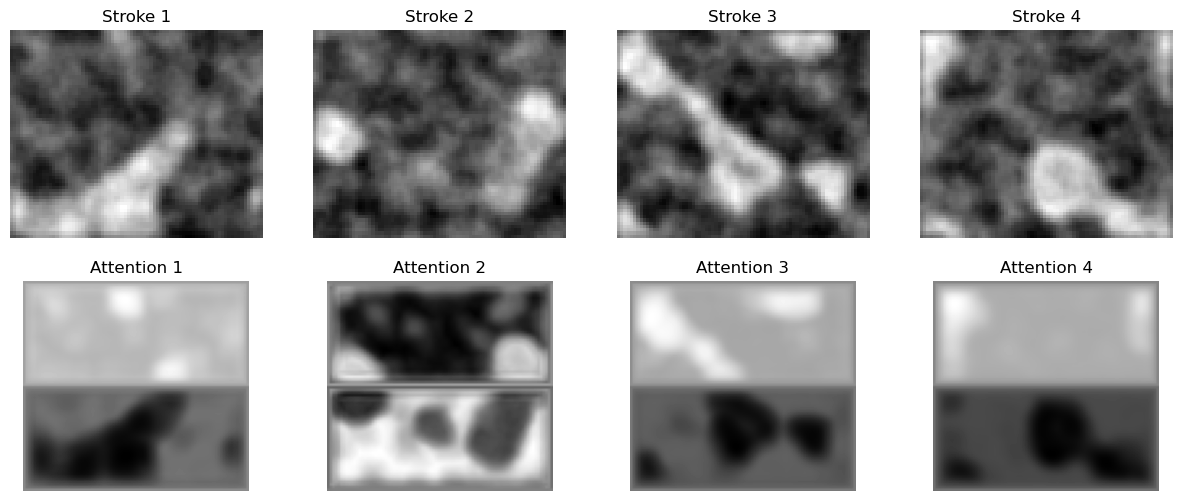

In [30]:
if isinstance(model, nn.DataParallel):
    model = model.module.cpu().eval()
else:
    model = model.cpu().eval()

fig, axs = plt.subplots(2, 4, figsize=(15, 6))

model.eval()
for i in range(4):
    
    left = torch.Tensor(stroke_X[i][:entity_shape[0]].copy())\
            .unsqueeze(dim=0).unsqueeze(dim=0)
    
    right = torch.Tensor(stroke_X[i][entity_shape[0]:][::-1].copy())\
            .unsqueeze(dim=0).unsqueeze(dim=0)
    
    left.requires_grad = True
    right.requires_grad = True
    
    out_left_1 = model.im1(left)
    out_left_2 = model.im2(out_left_1)
    out_left_3 = model.im3(out_left_2)
    out_left_4 = model.im4(out_left_3)
    
    out_right_1 = model.im1(right)
    out_right_2 = model.im2(out_right_1)
    out_right_3 = model.im3(out_right_2)
    out_right_4 = model.im4(out_right_3)
    
    out = torch.abs(out_left_4 - out_right_4)
    
    out = model.im5(out)
    out = model.im6(out)

    out = model.pool(out)
    
    out = out.view(out.shape[0], 38522880)
    out = F.sigmoid(model.fc(out))
    
    grad_left = torch.autograd.grad(out.squeeze()[0] - out.squeeze()[1], out_left_4, retain_graph=True)[0].squeeze()
    grad_right = torch.autograd.grad(out.squeeze()[0] - out.squeeze()[1], out_right_4, retain_graph=True)[0].squeeze()
    
    pooled_grad_left = torch.mean(grad_left, dim=(1, 2, 3)).view(grad_left.shape[0], 1, 1, 1)
    pooled_grad_right = torch.mean(grad_right, dim=(1, 2, 3)).view(grad_right.shape[0], 1, 1, 1)
    
    importances_left = torch.mean(out_left_4.squeeze(dim=0) * pooled_grad_left, dim=0).detach().cpu().numpy()
    importances_right = torch.mean(out_right_4.squeeze(dim=0) * pooled_grad_right, dim=0).detach().cpu().numpy()
    
    importances = np.concatenate((importances_left, importances_right[::-1]), axis=0)
    
    del left
    del right
    del out_left_1
    del out_left_2
    del out_left_3
    del out_left_4
    del out_right_1
    del out_right_2
    del out_right_3
    del out_right_4
    del out
    del grad_left
    del grad_right
    del pooled_grad_left
    del pooled_grad_right
    del importances_left
    del importances_right

    axs[0][i].imshow(stroke_X[i][:,:,13], cmap='gray')
    axs[0][i].set_title(f'Stroke {i+1}')
    axs[1][i].imshow(importances[:,:,importances.shape[2] // 2], cmap='gray')
    axs[1][i].set_title(f'Attention {i+1}')
    axs[0][i].set_axis_off()
    axs[1][i].set_axis_off()

fig.savefig('importances.png')

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    
model = model.to(device)

In [31]:
model_2d.train()
for epoch in tqdm(range(max_epoch_2d)):
    for i in range(math.ceil(len(train_X_2d) / batch_size_2d)):
        optimizer_2d.zero_grad()
        batch_X = np.array(train_X_2d[i * batch_size_2d:(i + 1) * batch_size_2d])
        batch_y = torch.Tensor(np.array(train_y_2d[i * batch_size_2d:(i + 1) * batch_size_2d])).to(device)
        
        left_batch = torch.Tensor(batch_X[:,:entity_shape[0]].copy()).to(device)
        right_batch = torch.Tensor(batch_X[:,entity_shape[0]:][:,::-1].copy()).to(device)
        outputs = model_2d(left_batch, right_batch)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_2d.step()

100%|██████████| 40/40 [01:54<00:00,  2.87s/it]


In [32]:
validate(model_2d, test_X_2d, test_y_2d)

100%|██████████| 60/60 [00:00<00:00, 86.57it/s]

              precision    recall  f1-score   support

      normal       0.76      0.93      0.84        30
      stroke       0.91      0.70      0.79        30

   micro avg       0.82      0.82      0.82        60
   macro avg       0.83      0.82      0.81        60
weighted avg       0.83      0.82      0.81        60
 samples avg       0.82      0.82      0.82        60

roc auc: 0.8605555555555555
accuracy: 0.8166666666666667


In [33]:
if isinstance(model, nn.DataParallel):
    model = model.module.cpu().eval()
else:
    model = model.cpu().eval()

im1_embs_3d_syntetic = []
im2_embs_3d_syntetic = []
im3_embs_3d_syntetic = []
im4_embs_3d_syntetic = []

for i in tqdm(range(42)):
    left = torch.Tensor(test_X_3d[i][:entity_shape[0]].copy()).unsqueeze(dim=0)
    im1_emb_3d = model.im1(torch.unsqueeze(left, 0)).detach()
    im2_emb_3d = model.im2(im1_emb_3d).detach()
    im3_emb_3d = model.im3(im2_emb_3d).detach()
    im4_emb_3d = model.im4(im3_emb_3d).detach()
    
    im1_embs_3d_syntetic.append(im1_emb_3d)
    im2_embs_3d_syntetic.append(im2_emb_3d)
    im3_embs_3d_syntetic.append(im3_emb_3d)
    im4_embs_3d_syntetic.append(im4_emb_3d)

100%|██████████| 42/42 [03:36<00:00,  5.15s/it]


In [34]:
im1_barcode_3d_syntetic = eXNN.topology.get_data_barcode(torch.cat(im1_embs_3d_syntetic), hom_type = "standard", coefs_type = "2")
del im1_embs_3d_syntetic
im2_barcode_3d_syntetic = eXNN.topology.get_data_barcode(torch.cat(im2_embs_3d_syntetic), hom_type = "standard", coefs_type = "2")
del im2_embs_3d_syntetic
im3_barcode_3d_syntetic = eXNN.topology.get_data_barcode(torch.cat(im3_embs_3d_syntetic), hom_type = "standard", coefs_type = "2")
del im3_embs_3d_syntetic
im4_barcode_3d_syntetic = eXNN.topology.get_data_barcode(torch.cat(im4_embs_3d_syntetic), hom_type = "standard", coefs_type = "2")
del im4_embs_3d_syntetic

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)

In [35]:
if isinstance(model_2d, nn.DataParallel):
    model_2d = model_2d.module.cpu().eval()
else:
    model_2d = model_2d.cpu().eval()

im1_embs_2d_syntetic = []
im2_embs_2d_syntetic = []
im3_embs_2d_syntetic = []
im4_embs_2d_syntetic = []

for i in tqdm(range(42)):
    left = torch.Tensor(test_X_2d[i][:entity_shape[0]].copy()).unsqueeze(dim=0)
    im1_emb_2d = model_2d.im1(torch.unsqueeze(left, 0)).detach()
    im2_emb_2d = model_2d.im2(im1_emb_2d).detach()
    im3_emb_2d = model_2d.im3(im2_emb_2d).detach()
    im4_emb_2d = model_2d.im4(im3_emb_2d).detach()
    
    im1_embs_2d_syntetic.append(im1_emb_2d.cpu())
    im2_embs_2d_syntetic.append(im2_emb_2d.cpu())
    im3_embs_2d_syntetic.append(im3_emb_2d.cpu())
    im4_embs_2d_syntetic.append(im4_emb_2d.cpu())

100%|██████████| 42/42 [00:03<00:00, 13.48it/s]


In [36]:
im1_barcode_2d_syntetic = eXNN.topology.get_data_barcode(torch.cat(im1_embs_2d_syntetic), hom_type = "standard", coefs_type = "2")
del im1_embs_2d_syntetic
im2_barcode_2d_syntetic = eXNN.topology.get_data_barcode(torch.cat(im2_embs_2d_syntetic), hom_type = "standard", coefs_type = "2")
del im2_embs_2d_syntetic
im3_barcode_2d_syntetic = eXNN.topology.get_data_barcode(torch.cat(im3_embs_2d_syntetic), hom_type = "standard", coefs_type = "2")
del im3_embs_2d_syntetic
im4_barcode_2d_syntetic = eXNN.topology.get_data_barcode(torch.cat(im4_embs_2d_syntetic), hom_type = "standard", coefs_type = "2")
del im4_embs_2d_syntetic

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model_2d)
model_2d = model_2d.to(device)

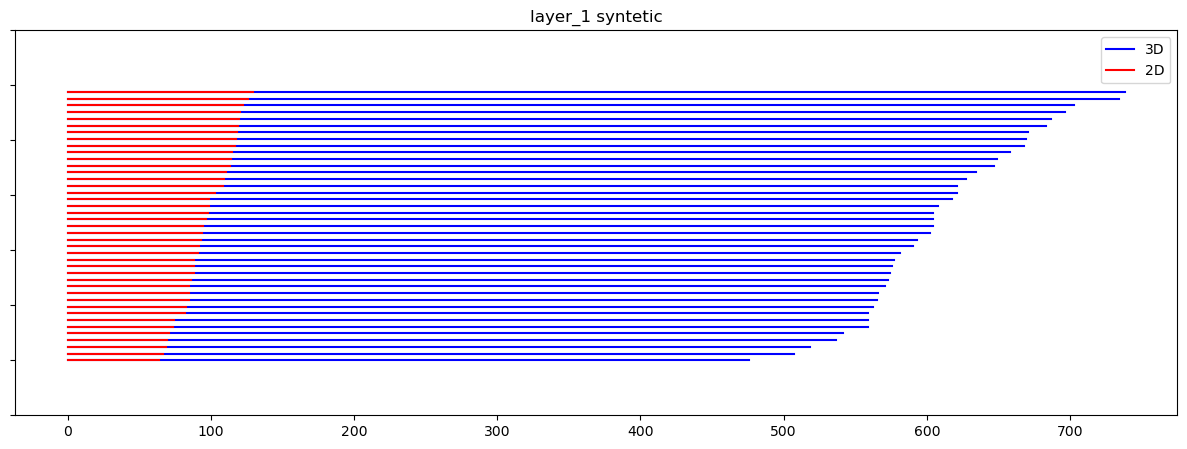

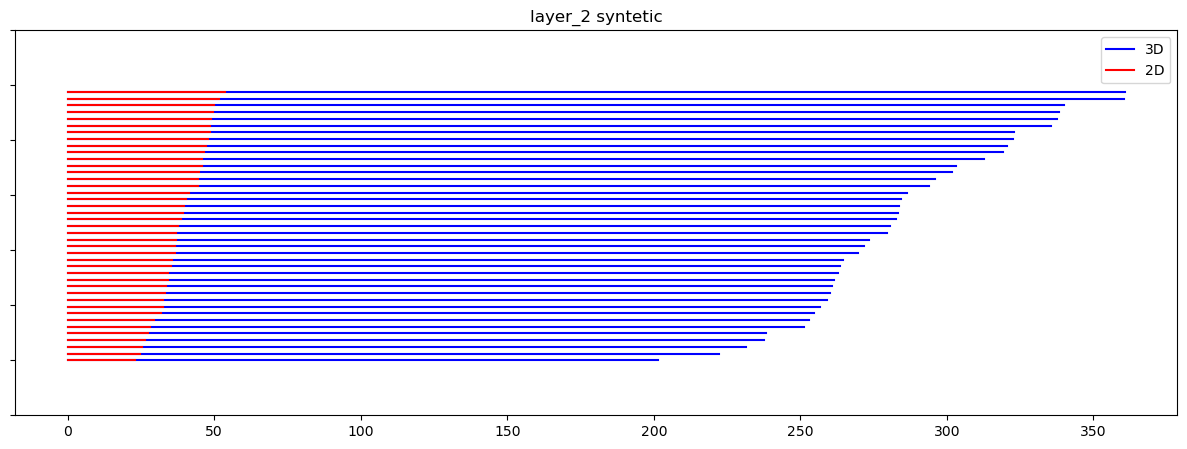

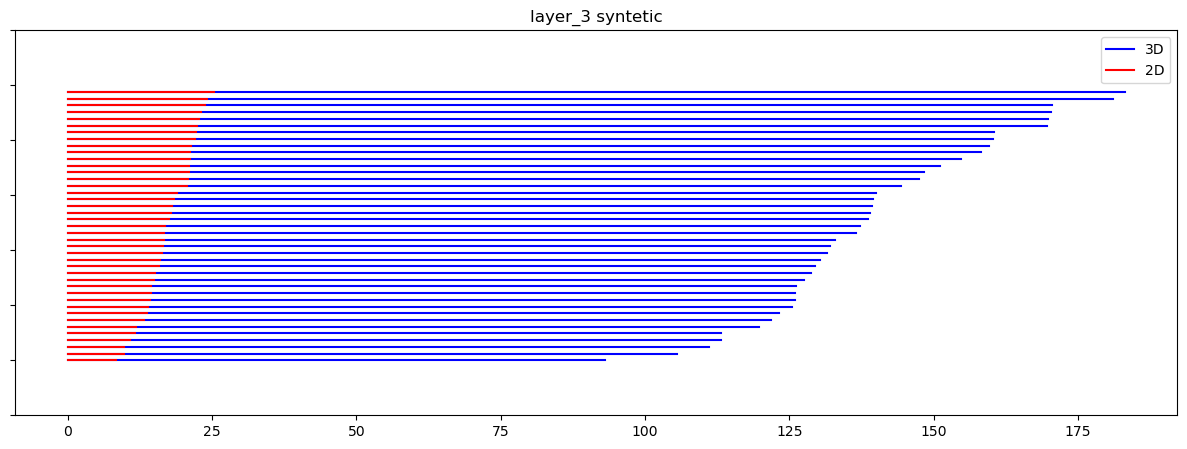

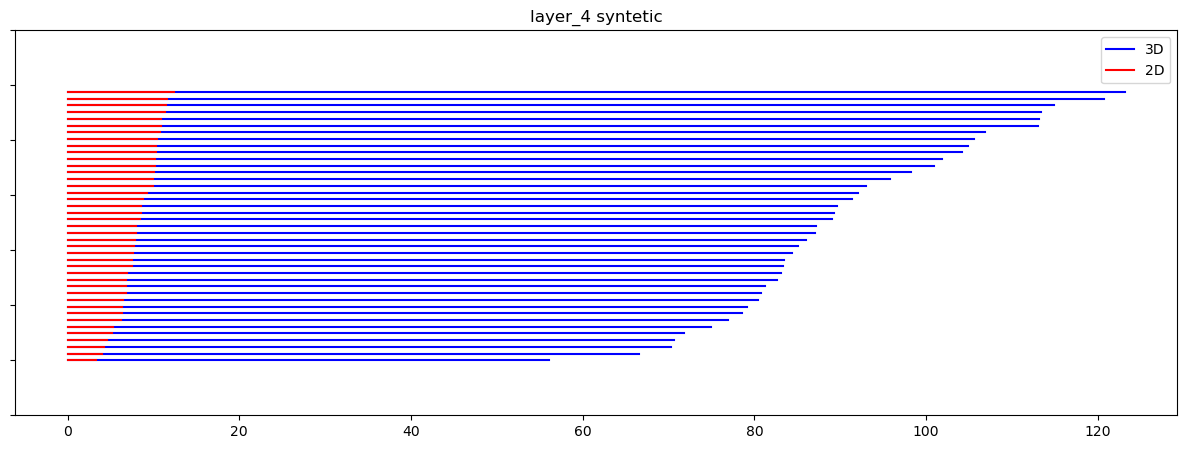

In [37]:
fig1 = plot_barcodes_overlay(im1_barcode_2d_syntetic, im1_barcode_3d_syntetic, 'layer_1 syntetic')
fig2 = plot_barcodes_overlay(im2_barcode_2d_syntetic, im2_barcode_3d_syntetic, 'layer_2 syntetic')
fig3 = plot_barcodes_overlay(im3_barcode_2d_syntetic, im3_barcode_3d_syntetic, 'layer_3 syntetic')
fig4 = plot_barcodes_overlay(im4_barcode_2d_syntetic, im4_barcode_3d_syntetic, 'layer_4 syntetic')

fig1.savefig('im1_syntetic.png')
fig2.savefig('im2_syntetic.png')
fig3.savefig('im3_syntetic.png')
fig4.savefig('im4_syntetic.png')

display(fig1)
display(fig2)
display(fig3)
display(fig4)

In [38]:
from eXNN.topology import evaluate_barcode

In [39]:
def renyi_entropy(values, alpha):
    values_sum = np.sum(values)
    return 1 / (1 - alpha) * np.log(np.sum(np.divide(values, values_sum) ** alpha))

In [40]:
metrics_dict = {feature: [] for feature in evaluate_barcode(im2_barcode_2d_syntetic)}
metrics_dict['layer'] = []
metrics_dict['is_syntetic'] = []
metrics_dict['is_3d'] = []

metrics_dict['renyi_entropy_05'] = []
metrics_dict['renyi_entropy_2'] = []
metrics_dict['renyi_entropy_3'] = []


for i, barcode in enumerate([im1_barcode_2d_syntetic,
                im2_barcode_2d_syntetic,
                im3_barcode_2d_syntetic,
                im4_barcode_2d_syntetic,
                im1_barcode_3d_syntetic,
                im2_barcode_3d_syntetic,
                im3_barcode_3d_syntetic,
                im4_barcode_3d_syntetic,
                im1_barcode_2d,
                im2_barcode_2d,
                im3_barcode_2d,
                im4_barcode_2d,
                im1_barcode_3d,
                im2_barcode_3d,
                im3_barcode_3d,
                im4_barcode_3d]):

    features = evaluate_barcode(barcode)
    
    for feature in features:
        metrics_dict[feature].append(features[feature])
        
    metrics_dict['renyi_entropy_05'].append(renyi_entropy([bar[1] for bar in barcode['H0']], 0.5))
    metrics_dict['renyi_entropy_2'].append(renyi_entropy([bar[1] for bar in barcode['H0']], 2))
    metrics_dict['renyi_entropy_3'].append(renyi_entropy([bar[1] for bar in barcode['H0']], 3))

    metrics_dict['layer'].append(i % 4 + 1)
    metrics_dict['is_syntetic'].append(i < 8)
    metrics_dict['is_3d'].append(3 < i < 8 or 11 < i)
    
barcode_metrics = pd.DataFrame(metrics_dict)

/opt/conda/lib/python3.10/site-packages/eXNN/topology/metrics.py:128: RuntimeWarning:

divide by zero encountered in double_scalars



In [41]:
barcode_metrics

,max_length,mean_length,median_length,stdev_length,sum_length,ratio_2_1,ratio_3_1,h,normh,snr,mean_birth,stdev_birth,mean_death,stdev_death,layer,is_syntetic,is_3d,renyi_entropy_05,renyi_entropy_2,renyi_entropy_3
0,129.578659,96.978335,94.267654,18.084136,3976.111740,1.970998,1.917468,3.695951,0.445937,inf,0.0,0.0,96.978335,18.084136,1,True,False,3.704642,3.679390,3.664041
1,53.811874,38.756627,37.520954,8.146830,1589.021715,2.237866,2.172024,3.691016,0.500757,inf,0.0,0.0,38.756627,8.146830,2,True,False,3.702072,3.670334,3.651625
2,25.296185,17.445259,16.891941,4.341487,715.255606,2.858380,2.808955,3.681361,0.560104,inf,0.0,0.0,17.445259,4.341487,3,True,False,3.696910,3.653481,3.629521
3,12.343888,8.223690,7.904736,2.282805,337.171289,3.493548,3.475270,3.672895,0.631018,inf,0.0,0.0,8.223690,2.282805,4,True,False,3.692264,3.639341,3.611582
4,738.019592,608.022929,604.016418,59.512341,24928.940094,1.542959,1.476618,3.708799,0.366345,inf,0.0,0.0,608.022929,59.512341,1,True,True,3.711185,3.704037,3.699295
5,360.613892,283.886743,280.501801,36.921495,11639.356461,1.788832,1.687339,3.705135,0.395757,inf,0.0,0.0,283.886743,36.921495,2,True,True,3.709342,3.696799,3.688590
6,183.041687,139.377710,137.189880,20.574180,5714.486122,1.947915,1.834083,3.702694,0.428020,inf,0.0,0.0,139.377710,20.574180,3,True,True,3.708110,3.692016,3.681571
7,123.120506,90.503066,87.131302,15.271171,3710.625702,2.154153,2.050331,3.699362,0.450101,inf,0.0,0.0,90.503066,15.271171,4,True,True,3.706426,3.685498,3.672036
8,144.208740,83.889140,80.824066,27.168535,3439.454727,3.275778,2.977986,3.661453,0.449640,inf,0.0,0.0,83.889140,27.168535,1,False,False,3.687099,3.613829,3.572122
9,99.353844,46.239803,48.089455,21.582884,1895.831923,5.488034,4.900027,3.605367,0.477696,inf,0.0,0.0,46.239803,21.582884,2,False,False,3.657346,3.516473,3.446105


In [42]:
barcode_metrics.to_excel('barcode_metrics.xlsx')

/tmp/ipykernel_27/478995943.py:1: FutureWarning:

write_cells is not part of the public API, usage can give unexpected results and will be removed in a future version

